In [1]:
import tensorflow as tf
import h5py
import explain
import custom_fit
import modelzoo
from loss import *
import os,json
import util
import pandas as pd
import importlib
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import metrics
import numpy as np
import yaml
import csv
import binary_comparison
import sklearn
import glob
import tfr_evaluate

# Compare 9 models in both binary and profile metrics

In [2]:
#binary_models
rb_bi = '/home/amber/QuantPred/paper_runs/binary/mod_binary/run-20211019_161849-9ygdmjss/files/best_model.h5'
basset_bi = '/home/amber/QuantPred/paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5'
#coverage models
rb_cov = '/home/amber/QuantPred/paper_runs/coverage/rb_global_cov.h5'
basset_cov = '/home/amber/QuantPred/paper_runs/coverage/Basset_cov.h5'
#profile models
bpnet_base = '/home/amber/QuantPred/paper_runs/bpnet/augmentation_48/run-20211006_190817-456uzbu4/files/best_model.h5'
basenji_128 = '/home/amber/QuantPred/paper_runs/basenji/augmentation_basenji/run-20210924_160405-psjsjf84/files/best_model.h5'
basenji_2k = '/home/amber/QuantPred/paper_runs/basenji/binloss_basenji/run-20210920_085441-14shgpx1/files/best_model.h5'
rb_32 ='/home/amber/QuantPred/paper_runs/new_models/32_res/run-20211023_095136-to28llil/files/best_model.h5'
rb_base = '/home/amber/QuantPred/paper_runs/new_models/base_res/run-20211022_141032-m1cjyb3z/files/best_model.h5'
#model_fn_dict
model_fn_dict={rb_bi:'rb_bi',basset_bi:'basset_bi',rb_cov:'rb_cov',basset_cov:'basset_cov',bpnet_base:'bpnet_base',
             basenji_128:'basenji_128',basenji_2k:'basenji_2k',rb_32:'rb_32',rb_base:'rb_base'}

In [3]:
#binary dataset
bi_peak_dataset = '/home/amber/QuantPred/datasets/binary/peak_center_test.h5'
bi_chr_dataset = '/home/amber/QuantPred/datasets/binary/test.h5'
profile_peak_dataset = '/home/shush/profile/QuantPred/datasets/complete/peak_centered/i_2048_w_1'
profile_chr_dataset = '/home/shush/profile/QuantPred/datasets/complete/random_chop/i_2048_w_1'

## Evaluate on AUROC/AUPR

In [4]:
import h5py
import modelzoo
import numpy as np
# f = h5py.File(bi_dataset,'r')
# y_test = f['y_test'][()]
# x_test = f['x_test'][()]
# f.close()

In [5]:
model_list = []
peak_aupr_list = []
peak_auroc_list = []

chr_aupr_list = []
chr_auroc_list = []

for model in model_fn_dict.keys():
    p_aupr,p_auroc = binary_comparison.binary_metrics(model,bi_peak_dataset)
    c_aupr,c_auroc = binary_comparison.binary_metrics(model,bi_chr_dataset)
    peak_aupr_list.append(p_aupr)
    peak_auroc_list.append(p_auroc)
    chr_aupr_list.append(c_aupr)
    chr_auroc_list.append(c_auroc)
    model_list.append(model_fn_dict[model])

In [6]:
bi_df = pd.DataFrame({'model':model_list,'peak aupr':peak_aupr_list,'peak auroc':peak_auroc_list,
                     'chrome aupr': chr_aupr_list,'chrom_auroc':chr_auroc_list})

In [7]:
bi_df

,model,peak aupr,peak auroc,chrome aupr,chrom_auroc
0,rb_bi,0.692850,0.871567,0.396624,0.856852
1,basset_bi,0.585901,0.791483,0.314453,0.780297
2,rb_cov,0.663903,0.861478,0.374688,0.879952
3,basset_cov,0.498852,0.710897,0.217261,0.733517
4,bpnet_base,0.659631,0.838377,0.506876,0.914321
5,basenji_128,0.650373,0.836745,0.488942,0.912492
6,basenji_2k,0.627498,0.813998,0.460035,0.895184
7,rb_32,0.707412,0.868770,0.561275,0.931332
8,rb_base,0.683123,0.850259,0.539550,0.920390


## Evaluate on coverage pearson R

In [8]:
import importlib
importlib.reload(binary_comparison)

pearson_c_list = []
pearson_p_list = []
model_fn = []

for model in [rb_cov,basset_cov,bpnet_base,basenji_128,basenji_2k,rb_32,rb_base]:
    p_r_list = binary_comparison.cov_pearson(model,profile_peak_dataset)
    c_r_list = binary_comparison.cov_pearson(model,profile_chr_dataset)
    pearson_c_list.append(np.mean(c_r_list))
    pearson_p_list.append(np.mean(p_r_list))
    model_fn.append(model_fn_dict[model])


for bi_model in [rb_bi,basset_bi]:
    p_r_list = binary_comparison.binary_to_profile(bi_model,profile_peak_dataset)
    c_r_list = binary_comparison.binary_to_profile(bi_model,profile_chr_dataset)
    pearson_c_list.append(np.mean(c_r_list))
    pearson_p_list.append(np.mean(p_r_list))
    model_fn.append(model_fn_dict[bi_model])
    

In [9]:
p_df = pd.DataFrame({'model':model_fn,'chr pearson r' :pearson_c_list,'peak pearson r' :pearson_p_list})

In [10]:
performance_df = pd.merge(bi_df,p_df)

In [11]:
performance_df = performance_df[['model','chrom_auroc','chrome aupr','chr pearson r','peak auroc','peak aupr','peak pearson r']]

In [14]:
performance_df['model type'] = ['Binary','Binary','Binary','Binary','Quantiative','Quantiative','Quantiative','Quantiative','Quantiative']

In [15]:
performance_df

,model,chrom_auroc,chrome aupr,chr pearson r,peak auroc,peak aupr,peak pearson r,model type
0,rb_bi,0.856852,0.396624,0.404047,0.871567,0.692850,0.621246,Binary
1,basset_bi,0.780297,0.314453,0.380003,0.791483,0.585901,0.543745,Binary
2,rb_cov,0.879952,0.374688,0.551990,0.861478,0.663903,0.680437,Binary
3,basset_cov,0.733517,0.217261,0.378554,0.710897,0.498852,0.500808,Binary
4,bpnet_base,0.914321,0.506876,0.673858,0.838377,0.659631,0.662583,Quantiative
5,basenji_128,0.912492,0.488942,0.668200,0.836745,0.650373,0.653664,Quantiative
6,basenji_2k,0.895184,0.460035,0.656958,0.813998,0.627498,0.642830,Quantiative
7,rb_32,0.931332,0.561275,0.704188,0.868770,0.707412,0.698668,Quantiative
8,rb_base,0.920390,0.539550,0.696068,0.850259,0.683123,0.686464,Quantiative


In [16]:
#write evaluation results
performance_df.to_csv('/home/amber/QuantPred/datasets/binary/performance.csv')

## Read existing results

In [17]:
import tensorflow as tf
import h5py
import explain
import custom_fit
import modelzoo
from loss import *
import os,json
import util
import pandas as pd
import importlib
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import metrics
import numpy as np
import yaml
import csv
import binary_comparison
import sklearn
import glob
import tfr_evaluate

In [18]:
df = pd.read_csv('/home/amber/QuantPred/datasets/binary/performance.csv',index_col = 0)

In [19]:
df

,model,chrom_auroc,chrome aupr,chr pearson r,peak auroc,peak aupr,peak pearson r,model type
0,rb_bi,0.856852,0.396624,0.404047,0.871567,0.692850,0.621246,Binary
1,basset_bi,0.780297,0.314453,0.380003,0.791483,0.585901,0.543745,Binary
2,rb_cov,0.879952,0.374688,0.551990,0.861478,0.663903,0.680437,Binary
3,basset_cov,0.733517,0.217261,0.378554,0.710897,0.498852,0.500808,Binary
4,bpnet_base,0.914321,0.506876,0.673858,0.838377,0.659631,0.662583,Quantiative
5,basenji_128,0.912492,0.488942,0.668200,0.836745,0.650373,0.653664,Quantiative
6,basenji_2k,0.895184,0.460035,0.656958,0.813998,0.627498,0.642830,Quantiative
7,rb_32,0.931332,0.561275,0.704188,0.868770,0.707412,0.698668,Quantiative
8,rb_base,0.920390,0.539550,0.696068,0.850259,0.683123,0.686464,Quantiative


Text(0.5, 1.0, 'performance on whole chromosome test set')

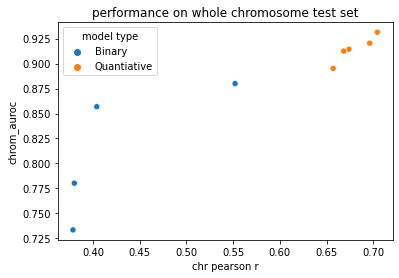

In [20]:
ax = sns.scatterplot(data = df, x = 'chr pearson r', y = 'chrom_auroc',hue = 'model type')
ax.set_title('performance on whole chromosome test set')

Text(0.5, 1.0, 'performance on peak centered test set')

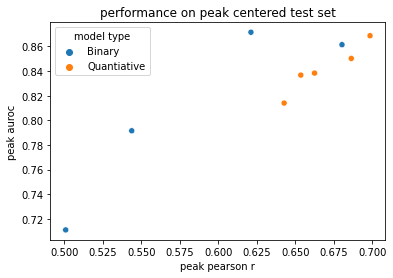

In [21]:
ax = sns.scatterplot(data = df, x = 'peak pearson r', y = 'peak auroc',hue = 'model type')
ax.set_title('performance on peak centered test set')

# Binary performance evaluation on the whole tes chr

In [ ]:
import importlib
import binary_comparison
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
run_dir = '/home/amber/QuantPred/paper_wandb/fintune_9/run-20210930_114050-50txx53v'
dataset = '/home/amber/QuantPred/datasets/binary/test.h5'
binary_dir = '/home/amber/QuantPred/binary_model/run-20210831_022930-hiln8r84/files/model-best.h5'

In [5]:
importlib.reload(binary_comparison)
p_profile,f_profile= binary_comparison.profile_to_binary(run_dir,dataset)

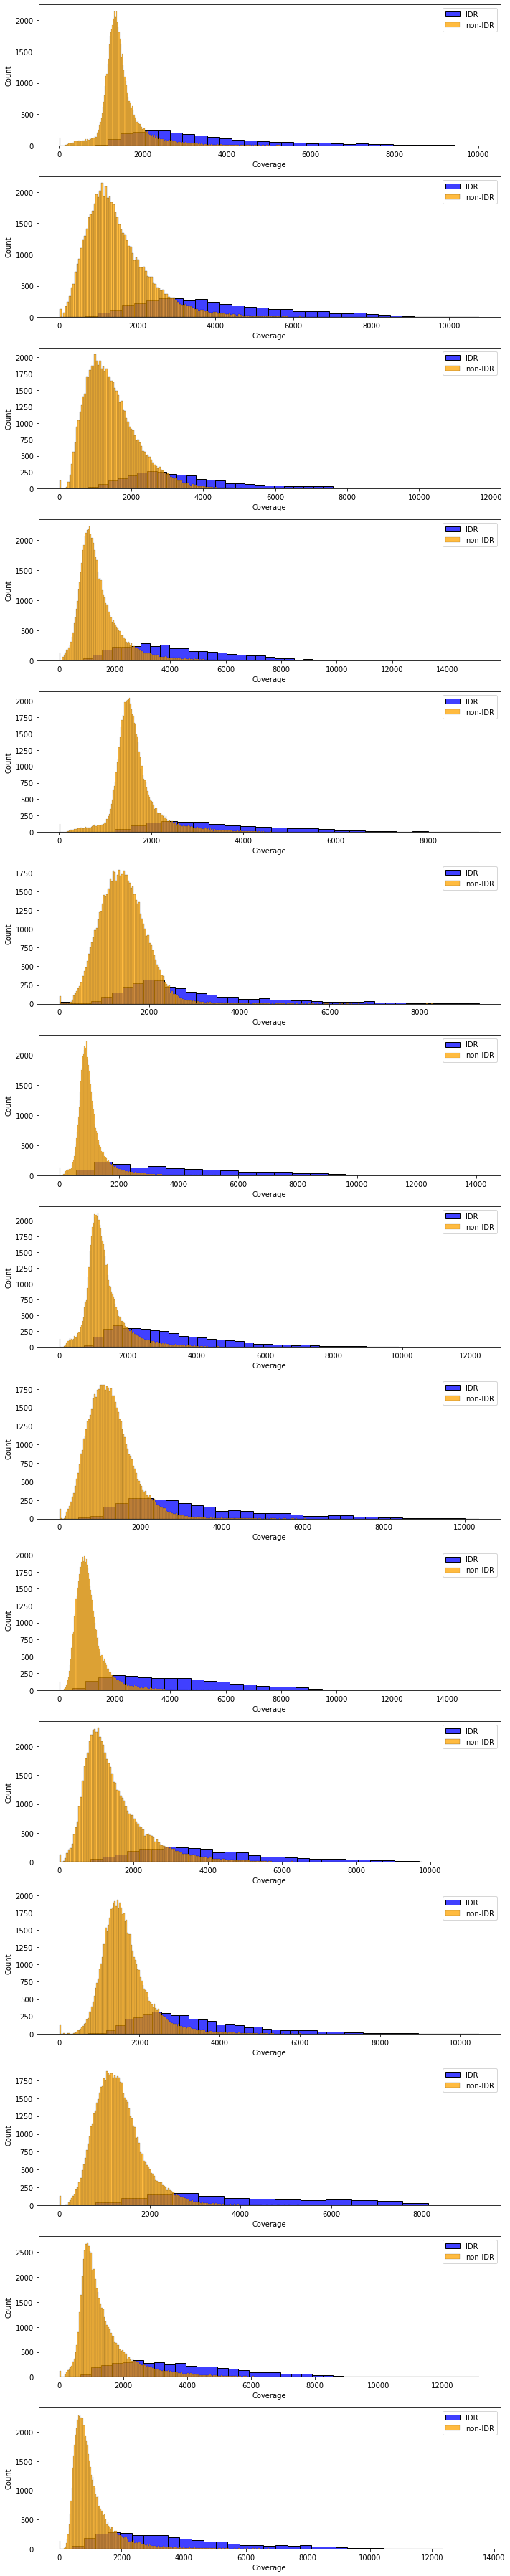

In [6]:
fig, axs = plt.subplots(15, 1, figsize=(10,50))
for i in range(0,15):
    test = sns.histplot(p_profile[i],color = 'blue',label = 'IDR',ax = axs[i])
    test = sns.histplot(f_profile[i],color = 'orange',label = 'non-IDR',ax = axs[i])
    test.set(xlabel='Coverage', ylabel='Count')
    test.legend()

plt.tight_layout()
plt.show()

### calculate aupr/auroc

In [8]:
import h5py
import modelzoo
import numpy as np
f = h5py.File(dataset,'r')
y_test = f['y_test'][()]
x_test = f['x_test'][()]
f.close()

In [9]:
model = modelzoo.load_model(run_dir,False)
y_pred = model.predict(x_test)
cov_pred = np.sum(y_pred,axis = 1)

In [14]:
import sklearn
aupr = []
auroc = []
for i in range(0,15):
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_test[:,i],cov_pred[:,i])
    fpr,tpr,threshold = sklearn.metrics.roc_curve(y_test[:,i],cov_pred[:,i])
    aupr.append(sklearn.metrics.auc(recall,precision))
    auroc.append(sklearn.metrics.auc(fpr,tpr))
print('profile_aupr')
print(np.mean(aupr))
print('profile_auroc')
print(np.mean(auroc))

profile_aupr
0.49380834007592084
profile_auroc
0.9167206924943859


In [16]:
binary_model = tf.keras.models.load_model(binary_dir)
binary_pred = binary_model.predict(x_test)
b_aupr = []
b_auroc = []
for i in range(0,15):
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_test[:,i],binary_pred[:,i])
    fpr,tpr,threshold = sklearn.metrics.roc_curve(y_test[:,i],binary_pred[:,i])
    b_aupr.append(sklearn.metrics.auc(recall,precision))
    b_auroc.append(sklearn.metrics.auc(fpr,tpr))
print('binary_aupr')
print(np.mean(b_aupr))
print('binary_auroc')
print(np.mean(b_auroc))

binary_aupr
0.3719926611930349
binary_auroc
0.8425364630594585


## Binary performance evaluation on IDR peak test set

In [17]:
import importlib
import binary_comparison
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
run_dir = '/home/amber/QuantPred/paper_wandb/fintune_9/run-20210930_114050-50txx53v'
dataset = '/home/amber/QuantPred/datasets/binary/peak_center_test.h5'

In [19]:
importlib.reload(binary_comparison)
p_profile,f_profile= binary_comparison.profile_to_binary('/home/amber/QuantPred/paper_wandb/fintune_9/run-20210930_114050-50txx53v','/home/amber/QuantPred/datasets/binary/peak_center_test.h5')

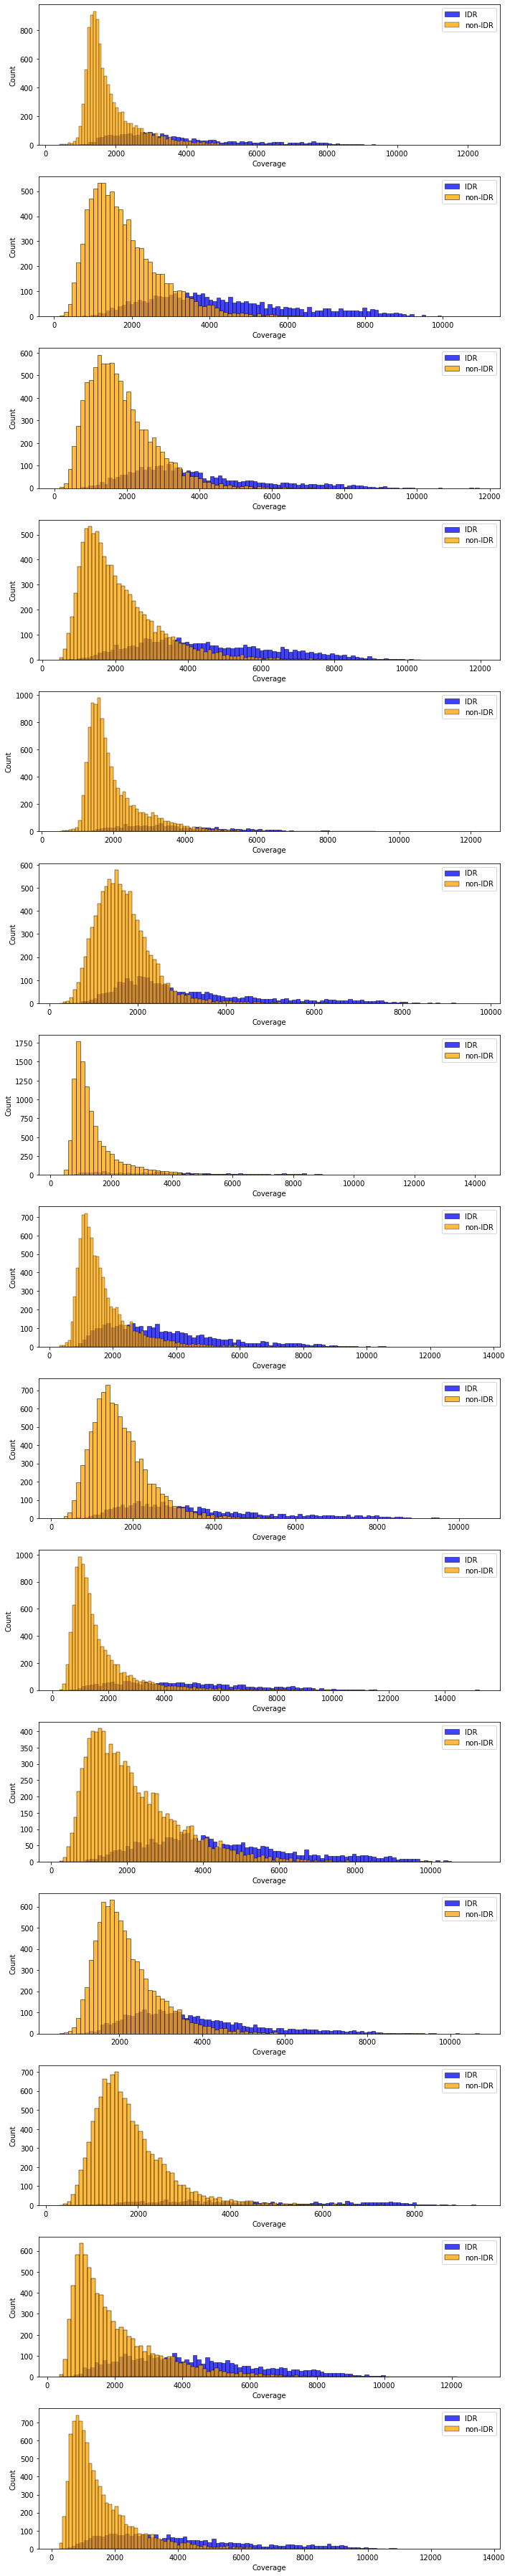

In [20]:
fig, axs = plt.subplots(15, 1, figsize=(10,50))
for i in range(0,15):
    test = sns.histplot(p_profile[i],color = 'blue',label = 'IDR',ax = axs[i],bins= 100)
    test = sns.histplot(f_profile[i],color = 'orange',label = 'non-IDR',ax = axs[i],bins = 100)
    test.set(xlabel='Coverage', ylabel='Count')
    test.legend()

plt.tight_layout()
plt.show()

#### Try calculate AUPR

In [21]:
import h5py
import modelzoo
import numpy as np
f = h5py.File(dataset,'r')
y_test = f['y_test'][()]
x_test = f['x_test'][()]
f.close()

In [22]:
model = modelzoo.load_model(run_dir,False)
y_pred = model.predict(x_test)
cov_pred = np.sum(y_pred,axis = 1)

In [23]:
import sklearn
aupr = []
auroc = []
for i in range(0,15):
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_test[:,i],cov_pred[:,i])
    fpr,tpr,threshold = sklearn.metrics.roc_curve(y_test[:,i],cov_pred[:,i])
    aupr.append(sklearn.metrics.auc(recall,precision))
    auroc.append(sklearn.metrics.auc(fpr,tpr))
print('profile_aupr')
print(np.mean(aupr))
print('profile_auroc')
print(np.mean(auroc))

profile_aupr
0.6937007420080988
profile_auroc
0.8703319201170673


In [24]:
binary_model = tf.keras.models.load_model(binary_dir)
binary_pred = binary_model.predict(x_test)
b_aupr = []
b_auroc = []
for i in range(0,15):
    precision,recall,threshold = sklearn.metrics.precision_recall_curve(y_test[:,i],binary_pred[:,i])
    fpr,tpr,threshold = sklearn.metrics.roc_curve(y_test[:,i],binary_pred[:,i])
    b_aupr.append(sklearn.metrics.auc(recall,precision))
    b_auroc.append(sklearn.metrics.auc(fpr,tpr))
print('binary_aupr')
print(np.mean(b_aupr))
print('binary_auroc')
print(np.mean(b_auroc))

binary_aupr
0.6877337426305801
binary_auroc
0.8701605299703075
